<a href="https://colab.research.google.com/github/thai94/d2l/blob/main/7.modern_convolutional_neural_networks/7_2_networks_using_blocks_vgg_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
!pip install livelossplot
from livelossplot import PlotLossesKeras

In [ ]:
def vgg_block(num_convs, num_channels):
    blk = tf.keras.models.Sequential()
    for _ in range(num_convs):
        blk.add(tf.keras.layers.Conv2D(num_channels,kernel_size=3,
                                    padding='same',activation='relu'))
    blk.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
    return blk

In [ ]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

In [ ]:
def vgg(conv_arch):
    net = tf.keras.models.Sequential()
    # The convulational part
    for (num_convs, num_channels) in conv_arch:
        net.add(vgg_block(num_convs, num_channels))
    # The fully-connected part
    net.add(tf.keras.models.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10)]))
    return net

net = vgg(conv_arch)

In [ ]:
X = tf.random.uniform((1, 224, 224, 1))
for blk in net.layers:
    X = blk(X)
    print(blk.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 (1, 112, 112, 64)
Sequential output shape:	 (1, 56, 56, 128)
Sequential output shape:	 (1, 28, 28, 256)
Sequential output shape:	 (1, 14, 14, 512)
Sequential output shape:	 (1, 7, 7, 512)
Sequential output shape:	 (1, 10)


In [ ]:
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = lambda: vgg(small_conv_arch)

In [ ]:
def load_data_fashion_mnist(batch_size, resize=None):
    """Download the Fashion-MNIST dataset and then load it into memory."""
    mnist_train, mnist_test = tf.keras.datasets.fashion_mnist.load_data()
    # Divide all numbers by 255 so that all pixel values are between
    # 0 and 1, add a batch dimension at the last. And cast label to int32
    process = lambda X, y: (tf.expand_dims(X, axis=3) / 255,
                            tf.cast(y, dtype='int32'))
    resize_fn = lambda X, y: (
        tf.image.resize_with_pad(X, resize, resize) if resize else X, y)
    return (
        tf.data.Dataset.from_tensor_slices(process(*mnist_train)).batch(
            batch_size).shuffle(len(mnist_train[0])).map(resize_fn),
        tf.data.Dataset.from_tensor_slices(process(*mnist_test)).batch(
            batch_size).map(resize_fn))

In [ ]:
def train_ch6(net_fn, train_iter, test_iter, num_epochs, lr, device):
  device_name = device._device_name
  strategy = tf.distribute.OneDeviceStrategy(device_name)
  with strategy.scope():
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    net = net_fn()
    net.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
  net.fit(train_iter, epochs=num_epochs, verbose=0, callbacks=[PlotLossesKeras()])
  return net

In [ ]:
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if len(tf.config.experimental.list_physical_devices('GPU')) >= i + 1:
        return tf.device(f'/GPU:{i}')
    return tf.device('/CPU:0')

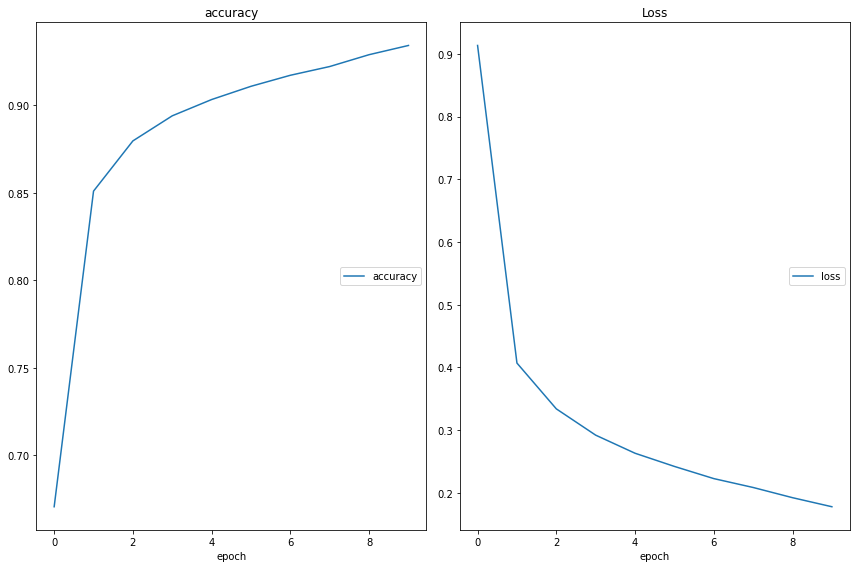

accuracy
	accuracy         	 (min:    0.671, max:    0.934, cur:    0.934)
Loss
	loss             	 (min:    0.178, max:    0.913, cur:    0.178)


In [ ]:
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = load_data_fashion_mnist(batch_size, resize=224)
train_ch6(net, train_iter, test_iter, num_epochs, lr, try_gpu())